# Boundary Relation Tests

## Setup

### Imports

In [1]:
# Shared Packages
import pandas as pd

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

## Boundary Check process
1. Build slice table (index= slice, columns = ROI, Data= StructureSlice)
2. Select Primary & Secondary ROI
	- Slice range = Min(starting slice) to Max(ending slice)
3. Send all slices with both Primary and Secondary contours for standard relation testing 
4. Identify the boundary slices of the Primary and Secondary ROI
    - Boundary slices are slices that have a contour, but one of their neighbouring slices do not have a contour.
5. For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.
6. For each of these neighbouring slices select a Secondary slice for boundary tests:
	- If the slice has a Secondary contour, select that Secondary slice.
	- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.
	- If neither the neighbouring slice nor the same slice as the Primary boundary have a Secondary contour, do not select a Secondary slice. Boundary testing is not required.
7. Test the relation between the boundary Primary and the selected Secondary.
8. Apply a Primary boundary shift to the relation results.
9. If the selected Secondary is also a Secondary boundary, apply a Secondary boundary shift as well.
10. Merge all results and reduce to single relation

# Current Bugs: 

1. The search for boundaries does not take into account holes in the structure.
2. Missing secondary boundary test
3. Borders definition appears to be incorrect

|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Borders          |  `FF*FT****`  |   `T*T*F*FF*`   | `*********` |
|Borders result   |  `000011001`  |   `000011001`   | `000011001` |
|Interior Borders |  `FF*FT****`  |   `T***T****`   | `*********` |
|Result           |  `111001001`  |   `111001001`   | `001011101` |
                
**BORDERS:** The two structures share a common exterior boundary.

**BORDERS_INTERIOR:** The two structures share a common boundary and one is within the other.
    


|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Overlaps         |  `T*T***T**`  |   `*********`   | `*********` |
|Overlaps result  |  `110010001`  |   `110010001`   | `110010001` |

                
**OVERLAPS:** The two structures share a common region.
    

![alt text](Images/DE-9IM.png)

![alt text](../reference/RelationshipTreeDiagram.svg)

In [ ]:
def identify_relation(relation_binary) -> RelationshipType:
    '''Applies a collection of definitions for named relationships to a supplied
    relationship binary.

    The defined relationships are:
        Relationship      Region Test   Exterior Test   Hull Test
        Disjoint          FF*FF****     FF*FF****       FF*FF****
        Shelters          FF*FF****     FF*FF****       TTT***F**
        Surrounds         FF*FF****     T***F*FF*
        Borders_Interior  FF*FT****     T***T****
        Borders           FF*FT****     T*T*F*FF*
        Contains          T*T*F*FF*
        Partition         T*T*T*FF*
        Equals	          T*F**FFF*
        Overlaps          T*T***T**

    Args:
        relation_binary (int): An integer generated from the combined DE-9IM
            tests.

    Returns:
        RelationshipType: The identified RelationshipType if one of the tests
            passes, otherwise RelationshipType.UNKNOWN.
    '''
    # Relationship Test Definitions
    test_binaries = [
        RelationshipTest(RelationshipType.SURROUNDS,
                         0b110110000100010000000000000,
                         0b000000000100000000000000000),
        RelationshipTest(RelationshipType.SHELTERS,
                         0b110110000100010000100010000,
                         0b000000000000000000100000000),
        RelationshipTest(RelationshipType.DISJOINT,
                         0b110110000100010000100010000,
                         0b000000000000000000000000000),
        RelationshipTest(RelationshipType.BORDERS,
                         0b100010000100010000000000000,
                         0b000010000000010000000000000),
        RelationshipTest(RelationshipType.BORDERS_INTERIOR,
                         0b100010000100010000000000000,
                         0b000010000100010000000000000),
        RelationshipTest(RelationshipType.OVERLAPS,
                         0b101010100101010100101000100,
                         0b101010100101010100101000100),
        RelationshipTest(RelationshipType.PARTITION,
                         0b101010100101010100101000100,
                         0b101010000101010000101000000),
        RelationshipTest(RelationshipType.CONTAINS,
                         0b110110000100010000100000000,
                         0b100000000100000000100000000),
        RelationshipTest(RelationshipType.EQUALS,
                         0b101010000100010000100000000,
                         0b100010000100010000100000000),
        ]
    for rel_def in test_binaries:
        result = rel_def.test(relation_binary)
        if result:
            return result
    return RelationshipType.UNKNOWN

## Test structures


#### Concentric cylinders starting on the same slice
  
<img src="Images\Boundaries\PartitionSup3D.png" alt="PartitionSup3D" style="height:50px;">
<img src="Images\Boundaries\PartitionSup2D.png" alt="PartitionSup2D" style="height:30px;">

In [4]:
def concentric_cylinders_same_start():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    sup_partition = make_vertical_cylinder(roi_num=2, radius=1, length=0.4,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, sup_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(concentric_cylinders_same_start(), [1, 2]))


Relationship: Partition


#### Concentric cylinders ending on the same slice.

<img src="Images\Boundaries\PartitionInf3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\PartitionInf2D.png" alt="PartitionInf2D" style="height:30px;">

In [5]:
def concentric_cylinders_same_end():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    inf_partition = make_vertical_cylinder(roi_num=3, radius=1, length=0.4,
                                           offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, inf_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(concentric_cylinders_same_end(), [1, 3]))


Relationship: Partition


- Concentric cylinders starting and ending on the same slice.

<img src="Images\Boundaries\Partition3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\Partition2D.png" alt="PartitionInf2D" style="height:30px;">

In [6]:
def concentric_cylinders_same_height():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting and ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    mid_partition = make_vertical_cylinder(roi_num=4, radius=1, length=0.7,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, mid_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(concentric_cylinders_same_height(), [1, 4]))


Relationship: Partition


### Exterior Borders
  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.

      
![Exterior Border SUP](Images/Boundaries/ExteriorBorders2D_SUP.png)
![Exterior Border INF](Images/Boundaries/ExteriorBorders2D_INF.png)

In [7]:
def stacked_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    outside_cylinder = make_vertical_cylinder(roi_num=5, radius=2, length=0.4,
                                              offset_z=-0.4,
                                              spacing=slice_spacing)
    inside_cylinder = make_vertical_cylinder(roi_num=6, radius=1, length=0.4,
                                             offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, outside_cylinder, inside_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(stacked_cylinders(), [5, 6]))


Relationship: Unknown


In [8]:
find_relationship(stacked_cylinders(), [5, 6])

<RelationshipType.UNKNOWN: 999>

In [9]:
selected_roi = [5, 6]
primary, secondary = selected_roi
slice_table = stacked_cylinders()
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
selected_slices

ROI Num,5,6
Slice Index,,
-0.4,<structure_slice.StructureSlice object at 0x00...,NaN
-0.3,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,NaN
-0.1,<structure_slice.StructureSlice object at 0x00...,NaN
0.0,NaN,<structure_slice.StructureSlice object at 0x00...
0.1,NaN,<structure_slice.StructureSlice object at 0x00...
0.2,NaN,<structure_slice.StructureSlice object at 0x00...
0.3,NaN,<structure_slice.StructureSlice object at 0x00...


In [10]:
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
mid_relations

Slice Index
-0.4   NaN
-0.3   NaN
-0.2   NaN
-0.1   NaN
 0.0   NaN
 0.1   NaN
 0.2   NaN
 0.3   NaN
Name: DE27IM, dtype: float64

In [11]:
# Test the relation between the boundary Primary and the selected Secondary.
matched_slices = boundary_match(slice_table, selected_roi)
bdry_rel = matched_slices.agg(relate_structures, structures=selected_roi,
                                axis='columns')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)


IdxB
0.0     111001001  |  111001001  |  111001001 
Name: DE27IM, dtype: object

In [12]:
# Apply a Primary boundary shift to the relation results.
bdry_rel = bdry_rel.apply(adjust_boundary_relation, shift_type='a')
# If the selected Secondary is also a Secondary boundary, apply a Secondary
#   boundary shift as well.
secondary_boundaries = find_boundary_slices(slice_table[secondary])
bdry_b = [idx for idx in secondary_boundaries
                            if idx in bdry_rel.index]
bdry_rel.loc[bdry_b] = bdry_rel[bdry_b].apply(adjust_boundary_relation,
                                                shift_type='b')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)

IdxB
0.0     000011001  |  000011001  |  000011001 
Name: DE27IM, dtype: object

### Interior Borders
  - Primary: Central Cylinder
  - Concentric shorter hole in the center of the primary cylinder
  - Secondary same height as hole but narrower
  - Interior borders at the and bottom of hole.
  
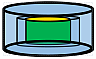
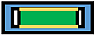

In [13]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=4, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=10, radius=1, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    reference = make_vertical_cylinder(roi_num=11, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole, middle_cylinder, reference])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(embedded_cylinder(), [9, 10]))


Relationship: Surrounds


In [14]:
selected_roi = [9, 10]
primary, secondary = selected_roi
slice_table = embedded_cylinder()
selected_slices = select_slices(slice_table, selected_roi)


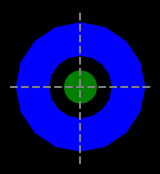

<Axes: >

In [15]:

plot_ab(slice_table.at[0.2,9].contour, slice_table.at[0.2,10].contour)

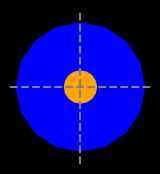

<Axes: >

In [16]:

plot_ab(slice_table.at[0.3,9].contour, slice_table.at[0.2,10].contour)

In [17]:
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
mid_relations.apply(bin_format)

Slice Index
-0.3                                           
-0.2     111001001  |  111001001  |  001001111 
-0.1     111001001  |  111001001  |  001001111 
 0.0     111001001  |  111001001  |  001001111 
 0.1     111001001  |  111001001  |  001001111 
 0.2     111001001  |  111001001  |  001001111 
 0.3                                           
Name: DE27IM, dtype: object

In [18]:
# Test the relation between the boundary Primary and the selected Secondary.
matched_slices = boundary_match(slice_table, selected_roi)
bdry_rel = matched_slices.agg(relate_structures, structures=selected_roi,
                                axis='columns')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)


Series([], Name: DE27IM, dtype: float64)

In [19]:
# Apply a Primary boundary shift to the relation results.
bdry_rel = bdry_rel.apply(adjust_boundary_relation, shift_type='a')
# If the selected Secondary is also a Secondary boundary, apply a Secondary
#   boundary shift as well.
secondary_boundaries = find_boundary_slices(slice_table[secondary])
bdry_b = [idx for idx in secondary_boundaries
                            if idx in bdry_rel.index]
bdry_rel.loc[bdry_b] = bdry_rel[bdry_b].apply(adjust_boundary_relation,
                                                shift_type='b')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)

Series([], Name: DE27IM, dtype: float64)

In [20]:
def overlapping_cylinders():
    slice_spacing = 0.5
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two overlapping cylinders
    top_cylinder = make_vertical_cylinder(roi_num=7, radius=2, length=0.4, offset_z=-0.3, spacing=slice_spacing)
    bottom_cylinder = make_vertical_cylinder(roi_num=8, radius=2, length=0.4, offset_z=0, spacing=slice_spacing)
   # combine the contours
    slice_data = pd.concat([top_cylinder, bottom_cylinder, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(overlapping_cylinders(), [7, 8]))


Relationship: Equals


In [21]:
selected_roi = [7, 8]
primary, secondary = selected_roi
slice_table = overlapping_cylinders()
selected_slices = select_slices(slice_table, selected_roi)
selected_slices

ROI Num,7,8
Slice Index,,
-0.3,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,NaN
-0.1,<structure_slice.StructureSlice object at 0x00...,NaN
0.0,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.1,NaN,<structure_slice.StructureSlice object at 0x00...
0.2,NaN,<structure_slice.StructureSlice object at 0x00...
0.3,NaN,<structure_slice.StructureSlice object at 0x00...


In [22]:
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
mid_relations.apply(bin_format)

Slice Index
-0.3                                           
-0.2                                           
-0.1                                           
 0.0     100010001  |  100010001  |  100010001 
 0.1                                           
 0.2                                           
 0.3                                           
Name: DE27IM, dtype: object

In [23]:
# Test the relation between the boundary Primary and the selected Secondary.
matched_slices = boundary_match(slice_table, selected_roi)
bdry_rel = matched_slices.agg(relate_structures, structures=selected_roi,
                                axis='columns')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)


IdxB
0.1     100010001  |  100010001  |  100010001 
Name: DE27IM, dtype: object

## Missing secondary boundary test

In [24]:
# Apply a Primary boundary shift to the relation results.
bdry_rel = bdry_rel.apply(adjust_boundary_relation, shift_type='a')
# If the selected Secondary is also a Secondary boundary, apply a Secondary
#   boundary shift as well.
bdry_rel.apply(bin_format)

secondary_boundaries = find_boundary_slices(slice_table[secondary])
print(secondary_boundaries)
bdry_b = [idx for idx in secondary_boundaries
                            if idx in bdry_rel.index]
print(bdry_b)
bdry_rel.loc[bdry_b] = bdry_rel[bdry_b].apply(adjust_boundary_relation,
                                                shift_type='b')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)

[0.0, 0.3]
[]


IdxB
0.1     010000001  |  010000001  |  010000001 
Name: DE27IM, dtype: object

In [25]:
# Merge all results and reduce to single relation
mid_relations = pd.concat([mid_relations, bdry_rel], axis='index',
                            ignore_index=True)
relation_binary = merge_rel(mid_relations)
bin_format(relation_binary)

' 110010001  |  110010001  |  110010001 '

# More Tests Needed

  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
- **Partition**
  - Concentric cylinders ending on the same slice.
  - Concentric cylinders starting on the same slice
  - Primary: Central Cylinder
    - Single Secondary slice with circular contour on the SUP/INF slice of the Primary cylinder.
  - Single Primary slice with circular contour
    - Secondary: one of:
      - SUP Cylinder ending on the same slice.
      - INF Cylinder ending on the same slice.
- **CONTAINS**
  - Concentric cylinders with interior cylinder ending inside the exterior cylinder by one slice
**OVERLAPS**
  - Concentric cylinders with interior cylinder ending outside the exterior cylinder by one slice
  - Concentric cylinders with interior cylinder consisting of single slice ending inside the exterior cylinder by one slice


  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.
  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
